In [1]:
import os
import abc
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from sklearn import metrics
from tqdm import tqdm

tf.random.set_seed(1234)
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
IMG_DIM = 32

In [5]:
def save_results(data, name):
    path = f'{os.getcwd()}/results/{name}.json'
    with open(path, 'w') as fout:
        json.dump(data, fout, indent=1)


def read_results(name):
    path = f'{os.getcwd()}/results/{name}.json'
    with open(path, 'r') as file:
        data = json.load(file)
    return data


def reduce_resolution(x_ds, dim = [IMG_DIM, IMG_DIM]):
    x_ds = tf.image.resize(
        x_ds, dim, 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    x_ds = tf.cast(x_ds, tf.float32) / 255.0
    return x_ds


def get_figure(title, ylabel, train_data, test_data):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()

    plt.title(f"{ylabel}, {title}")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)

    x = range(1, len(train_data) + 1)
    plt.xticks(np.arange(1, epochs+1))

    ax.plot(x, train_data, label=f'train {ylabel}')
    ax.plot(x, test_data, label=f'test {ylabel}')

    plt.legend()


def get_figure_multiple(title, ylabel, res, data_name):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()

    plt.title(f'{ylabel}, {title}')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)

    x = range(1, epochs+1)
    plt.xticks(np.arange(1, epochs+1))

    for r in res:
        ax.plot(x, r[f'train_{data_name}'], label=f'train, Dropout rate: {r["dropout_rate"]}')

    for r in res:
        ax.plot(x, r[f'test_{data_name}'], label=f'TEST, Dropout rate: {r["dropout_rate"]}')

    plt.legend()

In [6]:
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

x_train = dataset['train']['X']
x_train = reduce_resolution(x_train)
y_train = dataset['train']['y']

x_test = dataset['test']['X']
x_test = reduce_resolution(x_test)
y_test = dataset['test']['y']

x_vldt = dataset['validation']['X']
x_vldt = reduce_resolution(x_vldt)
y_vldt = dataset['validation']['y']

labels = dataset['labels_mapping']

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
train_ds = train_ds.shuffle(buffer_size=len(x_train)).batch(batch_size=128)

In [8]:
optimizer = tf.keras.optimizers.Adam
learning_rate = 0.001
epochs = 15
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

# Default CNN Model

In [13]:
class CNNModel(tf.keras.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=[3,3], 
                                            strides=(1,1),
                                            activation='relu',
                                            padding='same',
                                            input_shape=(IMG_DIM, IMG_DIM, 3))
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=[3,3], 
                                            strides=(1,1),
                                            activation='relu',
                                            padding='same',)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(units=384, activation='relu')
        self.fc2 = tf.keras.layers.Dense(units=192, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=14, activation='softmax')

    def call(self, inputs, training):
        if inputs.shape[0] > 1000:
            res = None
            ds = tf.data.Dataset.from_tensor_slices(inputs) 
            ds = ds.batch(batch_size=128)
            for d in ds:
                x = self.call(d, training)
                if res is None:
                    res = tf.identity(x)
                else:
                    res = tf.concat([res, x], 0)
        else:
            res = self._kelner_call(inputs, training)
        return res

    def fit(self, **kwargs):
        self.train_loss = []
        self.train_fscore = []
        self.test_loss = []
        self.test_fscore = []

        train_ds = kwargs['train_ds']
        x_test = kwargs['x_test']
        y_test = kwargs['y_test']
        cost_func = kwargs['cost_func']
        optimizer = kwargs['optimizer']
        learning_rate = kwargs['learning_rate']
        epochs = kwargs['epochs']

        optimizer = optimizer(learning_rate=learning_rate)

        for epoch in tqdm(range(epochs)):
            epoch_loss = []
            epoch_fscore = []

            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    outputs = self.call(x, True)
                    loss = cost_func(y, outputs)
                    pred = tf.math.argmax(outputs, axis=1).numpy()
                
                grads = tape.gradient(loss, self.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.trainable_variables))
                epoch_loss.append(loss)
                epoch_fscore.append(metrics.f1_score(tf.reshape(y, [-1]).numpy(), pred, average='macro'))

            self.train_loss.append((sum(epoch_loss) / float(len(epoch_loss))).numpy())
            self.train_fscore.append(sum(epoch_fscore) / float(len(epoch_fscore)))
            self.test_loss.append(cost_func(y_test, self.call(x_test, False)))
            self.test_fscore.append(metrics.f1_score(list(y_test), self.predict(x_test, False), average='macro'))

    def predict(self, x, training):
        test_ds = tf.data.Dataset.from_tensor_slices(x) 
        test_ds = test_ds.batch(batch_size=128)

        prediction = []
        for i in test_ds:
            res = self.call(i, False)
            prediction.extend([i.numpy() for i in tf.math.argmax(res, axis=1)])
        return prediction

    def _kelner_call(self, inputs, training):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [14]:
cnn_model = CNNModel()
cnn_model.fit(train_ds=train_ds, x_test=x_test, y_test=y_test, cost_func=cost_func,
            optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)

100%|██████████| 15/15 [01:52<00:00,  7.49s/it]


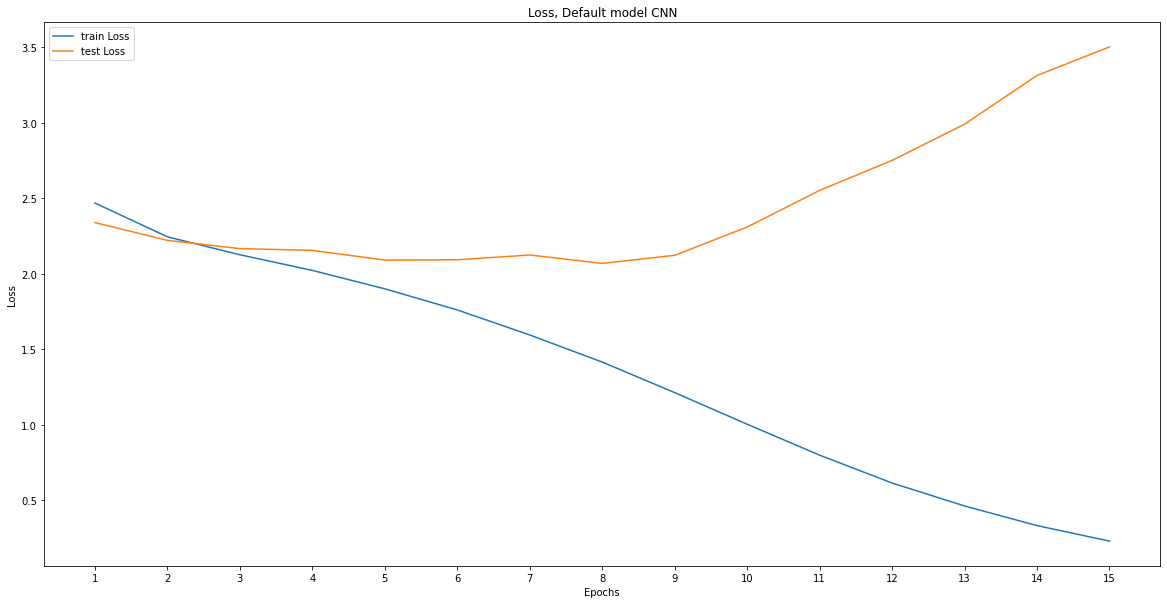

In [15]:
get_figure('Default model CNN', 'Loss', cnn_model.train_loss, cnn_model.test_loss)

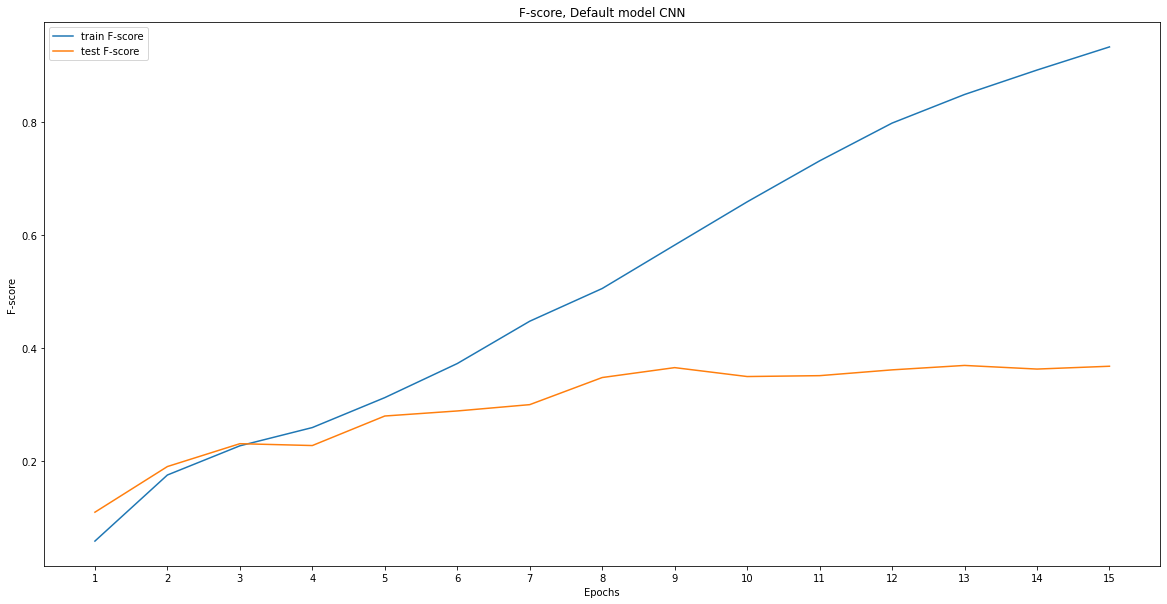

In [16]:
get_figure('Default model CNN', 'F-score', cnn_model.train_fscore, cnn_model.test_fscore)

## Wnioski

Sieć konwolucyjną zaimplementowano według architektury wskazanej w poprzednim zadaniu.

Sieć wyuczono na zbiorze treningowym z wykorzystaniem następnych paramertów: 
<pre>
- optimizer:        Adam 
- learning rate:    0.001
- cost func:        SparseCategoricalCrossentropy
- pooling layer:    MaxPool2D
- epochs:           15
- batch size:       128
- kernel size:      3x3
- pooling size:     2x2
</pre>

Osiągnięto `wynik miary fscore 0.35`.
Zauważono, że po 9 epoce straty wynoszą 2.27 i zaczynają rosnąć, a fscore zostaje się na poziomie 0.37 na zbiorze testowym, kiedy fscore na zbiorze treningowym rośnie i osiąga wartość 0.87.

# Model with Skip Connections

In [21]:
class CNNSkipModel(CNNModel):
    def __init__(self):
        super(CNNSkipModel, self).__init__()
        self.conv2 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=[3,3], 
                                            strides=(1,1),
                                            padding='same')
        self.conv_shortcut = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=[3,3], 
                                            strides=(2,2),
                                            padding='same')
        self.fc_shortcut = tf.keras.layers.Dense(units=14)
        self.fc3 = tf.keras.layers.Dense(units=14)
    
    def _kelner_call(self, inputs, training):
        x = self.conv1(inputs)
        x = self.pool1(x)

        x = self.conv2(x)
        x_shortcut = self.conv_shortcut(inputs)
        x = tf.keras.layers.Add()([x, x_shortcut])
        x = tf.keras.activations.relu(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x_shortcut = fc_shortcut(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        x = tf.keras.layers.Add()([x, x_shortcut])
        x = tf.keras.activations.softmax(x)

        return x


In [22]:
cnn_skip_model = CNNSkipModel()
cnn_skip_model.fit(train_ds=train_ds, x_test=x_test, y_test=y_test, cost_func=cost_func,
            optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)

100%|██████████| 15/15 [01:59<00:00,  7.94s/it]


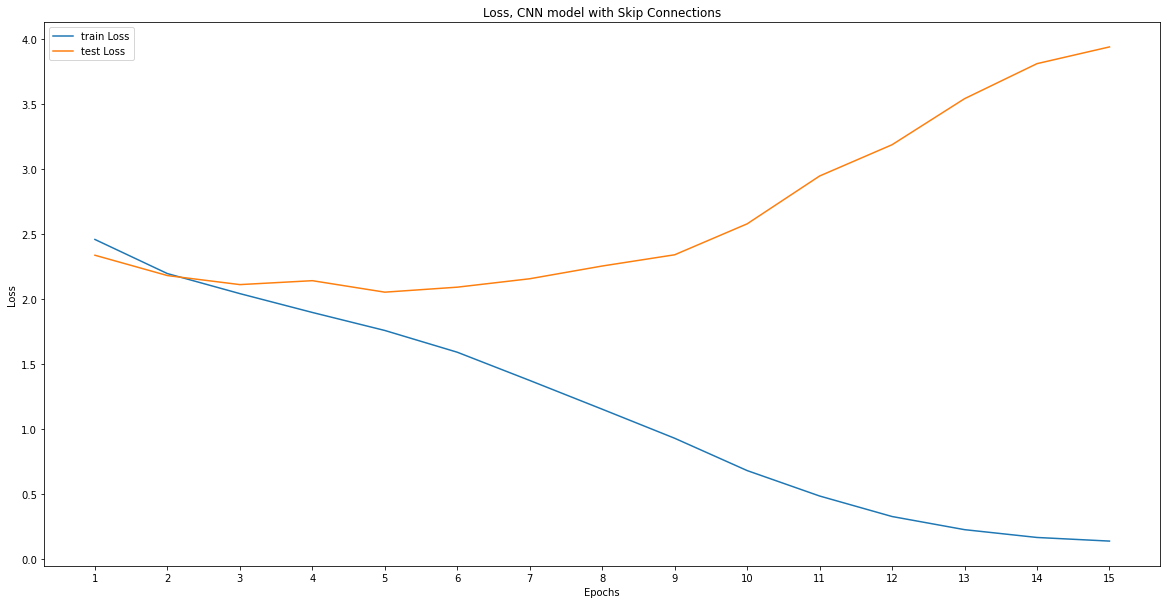

In [23]:
get_figure('CNN model with Skip Connections', 'Loss', cnn_skip_model.train_loss, cnn_skip_model.test_loss)

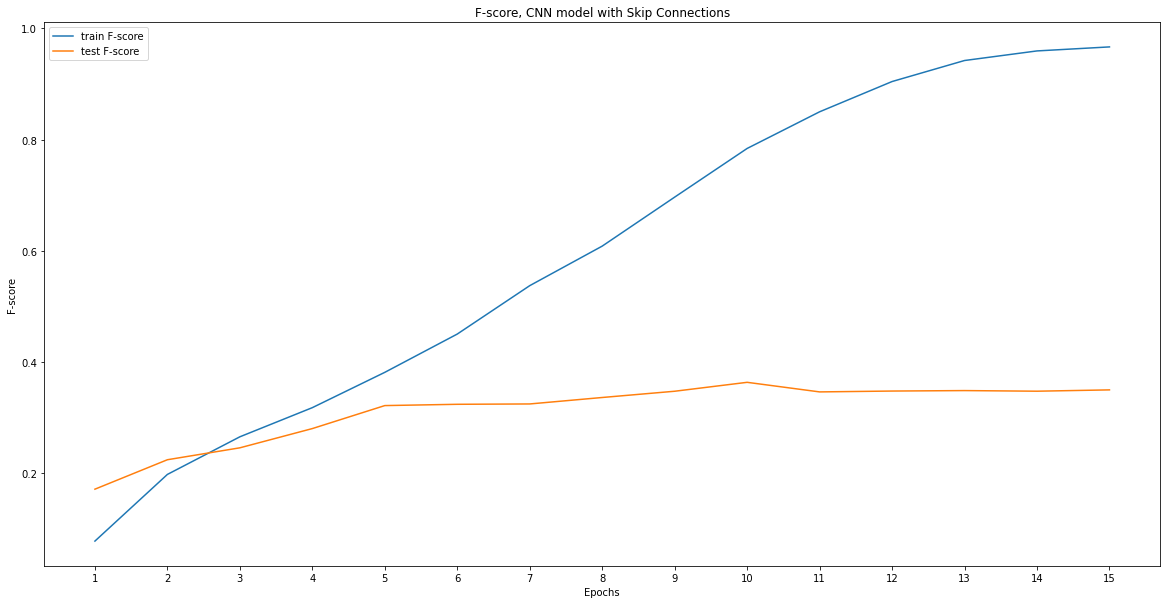

In [24]:
get_figure('CNN model with Skip Connections', 'F-score', cnn_skip_model.train_fscore, cnn_skip_model.test_fscore)

## Wnioski

Do poprzedniego modelu dodano 2 warstwy skip connections:
- po 2 warstwie konwolucyjnej. Przyjmuje ona tensor podany na wejściu sieci. Do redukcji wymiaru tensora podanego na wejściu została użyta warstwa konwolucyjna z krokiem [2,2]. Użyto warstwy Add do połączenia wyników. Po tej warstiwe następuje wywoływanie funkcji aktywacji ReLU i warstwy pooling.
- po ostatniej w pełni połączonej warstwie. Przyjmuje ona tensor otrzymany po warstwie Flatten. Do redukcji wymiaru tensora podanego na wejściu została użyta warstwa w pełni połączona. Po połączeniu wyników następuje wywoływanie funkcji aktywacji SoftMax. 

Wynik miary Fscore dla zbioru testowego nie róźni się od wyników oryginalnej sieci CNN i wynosi 0.37, ale straty są większe i osiągają wartości 3.78.
Na zbiorze treningowym wynik miary fscore osiąga 0.94, a funkcja straty pokazuje wyniki na poziomie 0.

# Model with Droput layers

In [25]:
class CNNDroputModel(CNNModel):
    def __init__(self, dropout_rate):
        super(CNNDroputModel, self).__init__()
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def _kelner_call(self, inputs, training):
        x = self.conv1(inputs)
        x = self.dropout1(x, training=training)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.dropout2(x, training=training)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [26]:
dropout_rates = [0.6, 0.4, 0.2]
results = []

for rate in dropout_rates:
    cnn_dropout_model = CNNDroputModel(rate)
    cnn_dropout_model.fit(train_ds=train_ds, x_test=x_test, y_test=y_test, cost_func=cost_func,
                            optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)
    results.append({'dropout_rate': rate,
                    'train_loss': [np.float64(i) for i in cnn_dropout_model.train_loss], 'train_fscore': list(cnn_dropout_model.train_fscore),
                    'test_loss': [np.float64(i.numpy()) for i in cnn_dropout_model.test_loss], 'test_fscore': list(cnn_dropout_model.test_fscore)
                    })


100%|██████████| 15/15 [02:26<00:00,  9.76s/it]


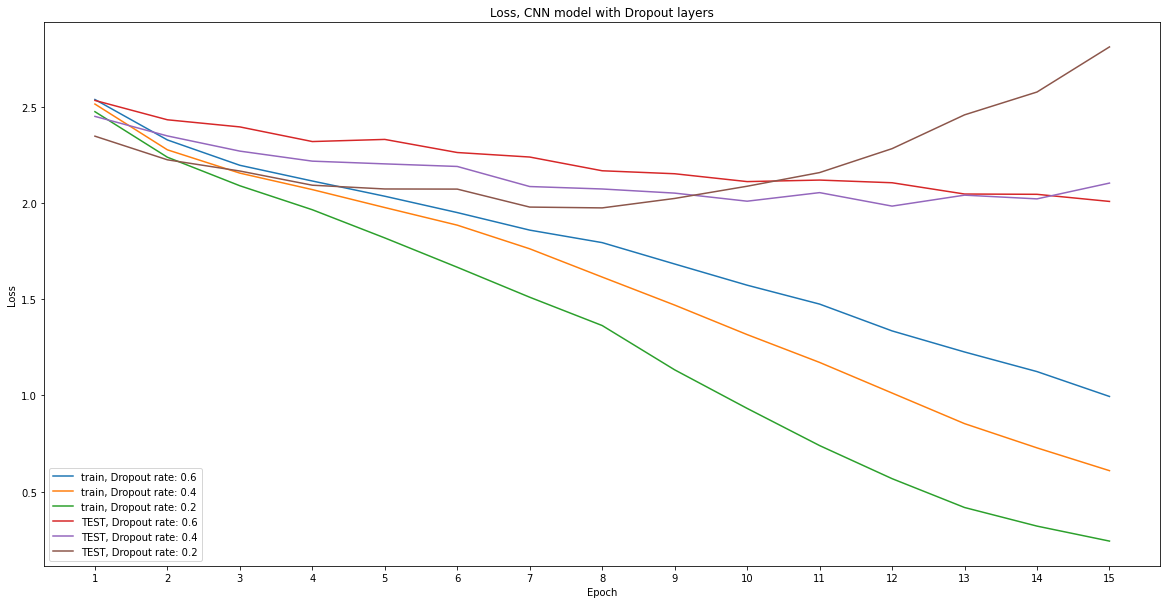

In [27]:
get_figure_multiple('CNN model with Dropout layers', 'Loss', results, 'loss')


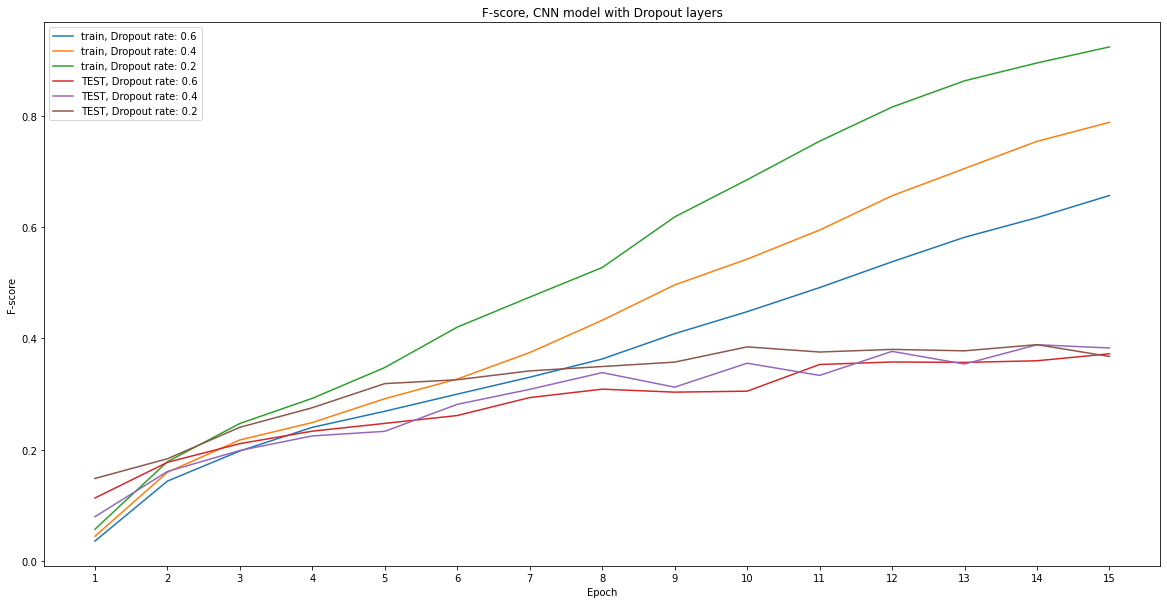

In [28]:
get_figure_multiple('CNN model with Dropout layers', 'F-score', results, 'fscore')

## Wnioski

Do oryginalnego modelu dodano 2 warstwy Dropout:
- po 1 warstwie konwolucyjnej z funkcją aktywacji ReLU i przed warstwą pooling. 
- po 2 warstwie konwolucyjnej z funkcją aktywacji ReLU i przed warstwą pooling. 

Do testów użyto następnych wartości parametru rate warstwy Dropout: [0.6, 0.4, 0.2]

Im więksa jest wartość parametru rate, tym mniejsze są straty dla treningowego i testowego zbiorów.
Sieć osiąga najlepsze wyniki, kiedy wartość parametru rate jest równa 0.2.
Wartość funkcji fscore jest nieco większa, a straty są mniejsze i wynoszą 2.9.

# Model with Batch Normalization Layers

In [31]:
class CNNBatchNormModel(CNNModel):
    def __init__(self):
        super(CNNBatchNormModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=[3,3], 
                                            strides=(1,1),
                                            padding='same',
                                            input_shape=(IMG_DIM, IMG_DIM, 3))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=[3,3], 
                                            strides=(1,1),
                                            padding='same')
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.bnorm2 = tf.keras.layers.BatchNormalization()
    
    def _kelner_call(self, inputs, training):
        x = self.conv1(inputs)
        x = self.bnorm1(x, training=training)
        x = tf.keras.activations.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bnorm2(x, training=training)
        x = tf.keras.activations.relu(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [32]:
cnn_batch_norm_model = CNNBatchNormModel()
cnn_batch_norm_model.fit(train_ds=train_ds, x_test=x_test, y_test=y_test, cost_func=cost_func,
            optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)

100%|██████████| 15/15 [02:22<00:00,  9.49s/it]


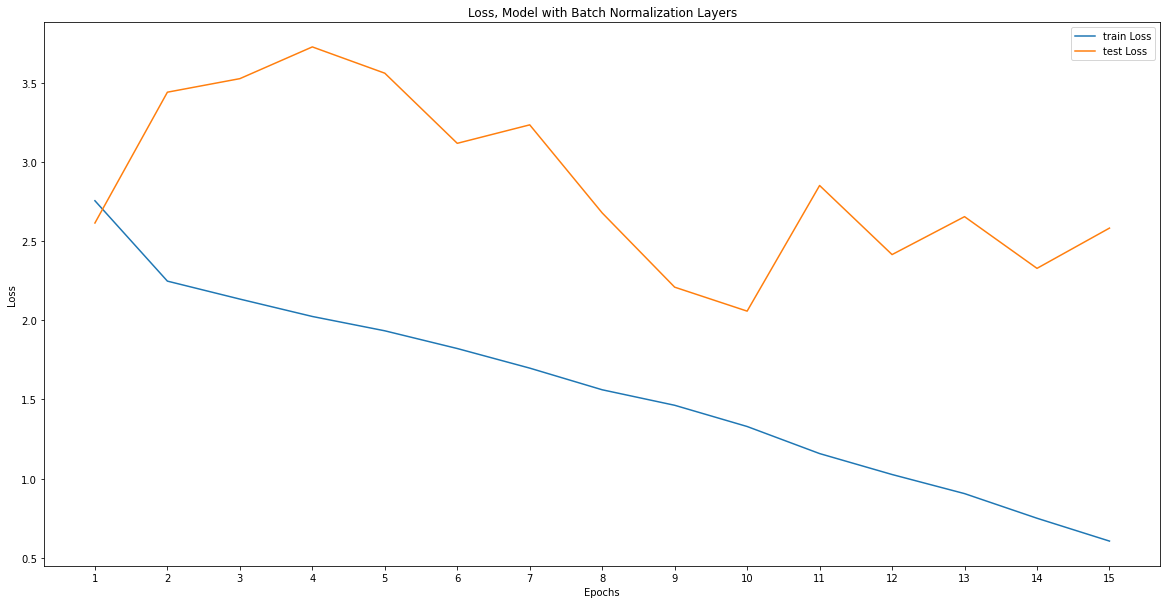

In [33]:
get_figure('Model with Batch Normalization Layers', 'Loss', cnn_batch_norm_model.train_loss, cnn_batch_norm_model.test_loss)

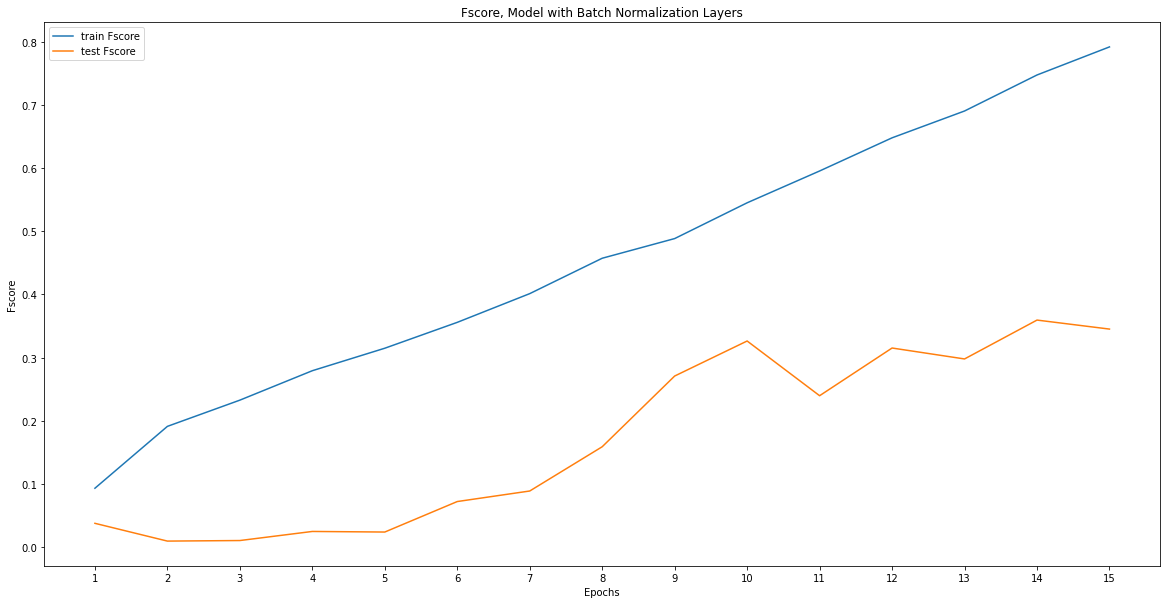

In [34]:
get_figure('Model with Batch Normalization Layers', 'Fscore', cnn_batch_norm_model.train_fscore, cnn_batch_norm_model.test_fscore)

## Wnioski

Do oryginalnego modelu dodano 2 warstwy Batch Normalization:
- po 1 warstwie konwolucyjnej przed funkcją aktywacji ReLU. 
- po 2 warstwie konwolucyjnej funkcją aktywacji ReLU. 

straty są mniejsze w porównaniu do oryginalnego modelu i wynoszą 2.5. Wartość miary Fscore też jest też mniejsza i wyosi 0.36. 

# Summary

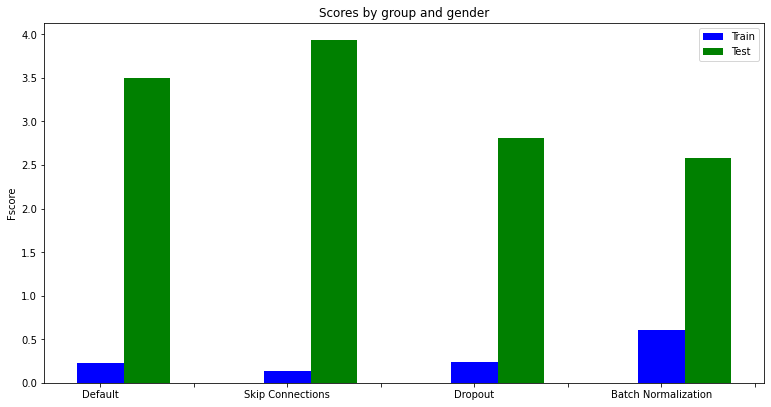

In [49]:
data = [[cnn_model.train_loss[-1], cnn_skip_model.train_loss[-1], cnn_dropout_model.train_loss[-1], cnn_batch_norm_model.train_loss[-1]],
[cnn_model.test_loss[-1], cnn_skip_model.test_loss[-1], cnn_dropout_model.test_loss[-1], cnn_batch_norm_model.test_loss[-1]]]
X = np.arange(4)
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.set_title('Scores by group and gender')
ax.set_ylabel('Fscore')
ax.set_xticklabels((None, 'Default', None, 'Skip Connections', None, 'Dropout', None, 'Batch Normalization'))
ax.legend(labels=['Train', 'Test'])

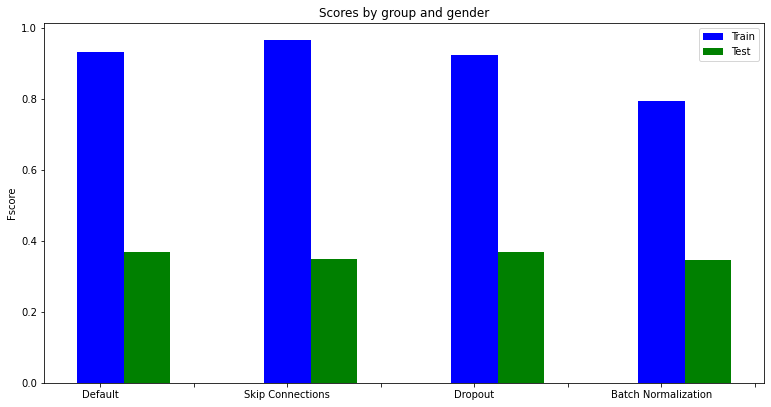

In [45]:
data = [[cnn_model.train_fscore[-1], cnn_skip_model.train_fscore[-1], cnn_dropout_model.train_fscore[-1], cnn_batch_norm_model.train_fscore[-1]],
[cnn_model.test_fscore[-1], cnn_skip_model.test_fscore[-1], cnn_dropout_model.test_fscore[-1], cnn_batch_norm_model.test_fscore[-1]]]
X = np.arange(4)
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.set_title('Scores by group and gender')
ax.set_ylabel('Fscore')
ax.set_xticklabels((None, 'Default', None, 'Skip Connections', None, 'Dropout', None, 'Batch Normalization'))
ax.legend(labels=['Train', 'Test'])

## Wnioski

Najmniejsze straty na zbiorze testowym pokazała sieć z Batch Normalization: 2.5. Na drugim miejscu jest sieć z warstwami Dropout, która pokazała wynik na poziomie 2.7. Największą wartość fscore osiągłą sieć z Dropout: 0.38. 

Sieć z warstwami dropout została wybrana do pokazywania wyników konfusion matrix i błędnie olejbowanych obrazów.

[Text(0.5, 0, 'indo-islamic'),
 Text(1.5, 0, 'chinese'),
 Text(2.5, 0, 'art_deco'),
 Text(3.5, 0, 'secession'),
 Text(4.5, 0, 'romanesque'),
 Text(5.5, 0, 'byzantine'),
 Text(6.5, 0, 'russian_revival'),
 Text(7.5, 0, 'victorian_quenn_anne'),
 Text(8.5, 0, 'neoclassical'),
 Text(9.5, 0, 'postmodernism'),
 Text(10.5, 0, 'baroque'),
 Text(11.5, 0, 'achaemenid'),
 Text(12.5, 0, 'ancient'),
 Text(13.5, 0, 'renaissance')]

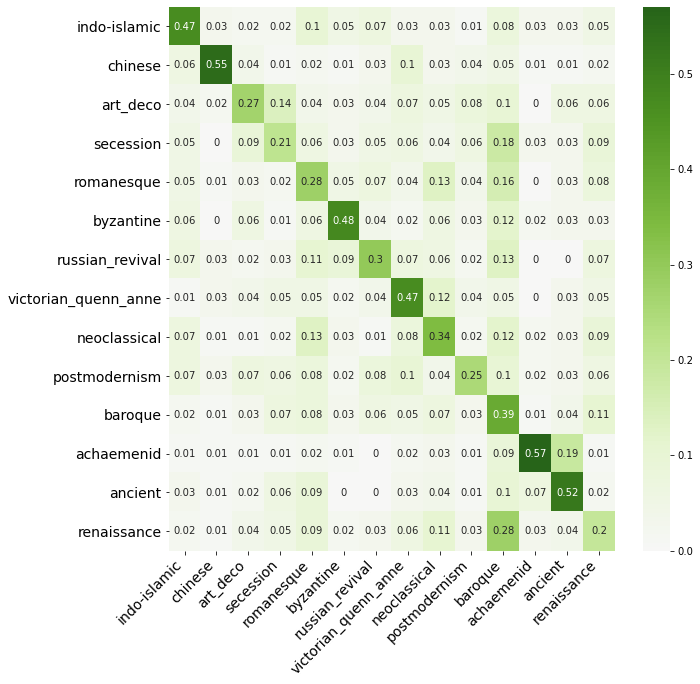

In [47]:
names = list(labels.keys())

test_dataset = (x_test, y_test)
y_pred = cnn_dropout_model.predict(x_test, False)
conf_matrix = tf.math.confusion_matrix(y_pred, y_test).numpy()
conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
fig, ax = plt.subplots(figsize=(10,10))   
ax = sns.heatmap(conf_matrix, cmap="PiYG",
            annot=True, center=0)
ax.yaxis.set_ticklabels(names, rotation=0, ha='right', fontsize=14)
ax.xaxis.set_ticklabels(names, rotation=45, ha='right', fontsize=14)

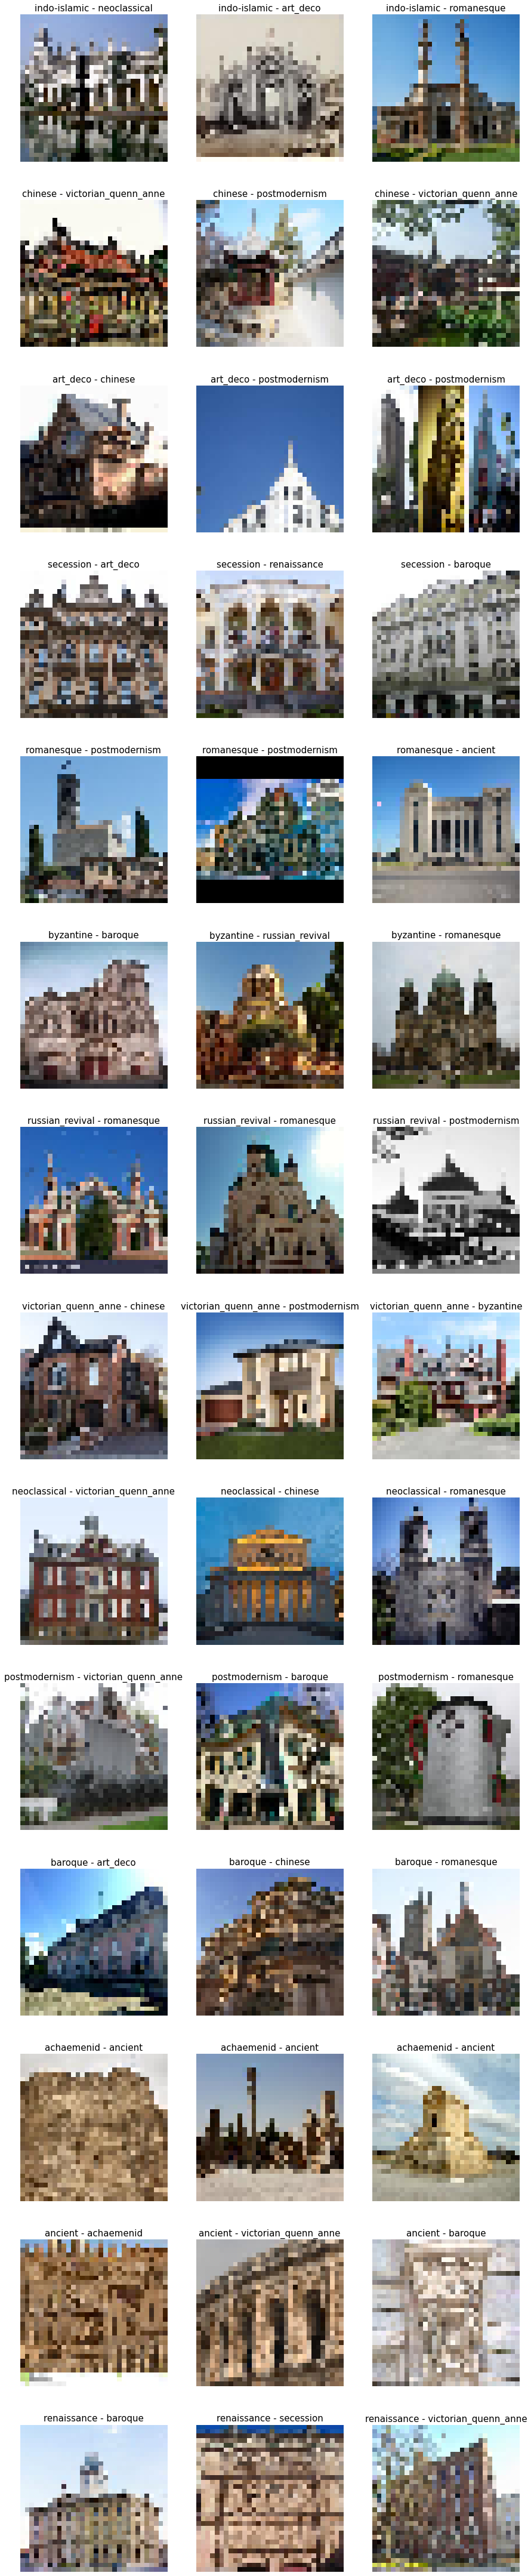

In [48]:
imgs, true_labels, pred_labels = [], [], []
max_exp = 3
# counter = np.zeros(len(labels))

for i in range(len(labels)):
    counter = 0
    for img, true_label, pred_label in zip(x_test, y_test, y_pred):
        if counter == 3: break
        if true_label == i and pred_label != true_label:
            imgs.append(img)
            pred_labels.append(pred_label)
            true_labels.append(true_label)
            counter += 1

fig = plt.figure(figsize=(15,80))
fig.subplots_adjust(wspace=0.2, hspace=0)
for n in range(42):
    ax = plt.subplot(14, 3, n+1)
    plt.imshow(imgs[n])
    title = f'{list(labels.keys())[true_labels[n]]} - {list(labels.keys())[pred_labels[n]]}'
    plt.title(title, fontsize = 15)
    plt.axis('off')

In [50]:
labels

{'indo-islamic': 0,
 'chinese': 1,
 'art_deco': 2,
 'secession': 3,
 'romanesque': 4,
 'byzantine': 5,
 'russian_revival': 6,
 'victorian_quenn_anne': 7,
 'neoclassical': 8,
 'postmodernism': 9,
 'baroque': 10,
 'achaemenid': 11,
 'ancient': 12,
 'renaissance': 13}

## Wnioski

W porównaniu do oryginalnej sieci confusion matrix zaczyna wyglądać bardziej sensowniej. Błądne tagi sieci da się interpretować. Np. 20% obrazów błędnie otagowanych jako achaemenid odnoszą się do klasy ancient, są z założenia podobne. Renissans jest mylony z baroque.